In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
plt.rcParams.update({'font.size': 15})

---
#### Analysis:


Import pickled LST time series for Tuolumne:

In [3]:
modis = pd.read_pickle("../pkl/tuolumne.pkl")

In [4]:
modis.head()

,index,datetime,temperature,viewangle,temp_min,temp_max,temp_mean
0,0,2017-04-10 03:40:00,-13.43,25.5,-13.43,-13.43,-13.43
1,1,2017-04-10 14:45:00,-1.05,33.0,-1.05,-1.05,-1.05
2,2,2017-04-11 04:25:00,NaN,nan,NaN,NaN,NaN
3,3,2017-04-11 15:30:00,NaN,nan,NaN,NaN,NaN
4,4,2017-04-12 03:30:00,-4.75,43.0,-4.75,-4.75,-4.75


Get rid of any rows with nan temperatures for now:

In [5]:
modis = modis[~modis.temperature.isnull()]

In [6]:
modis.head()

,index,datetime,temperature,viewangle,temp_min,temp_max,temp_mean
0,0,2017-04-10 03:40:00,-13.43,25.5,-13.43,-13.43,-13.43
1,1,2017-04-10 14:45:00,-1.05,33.0,-1.05,-1.05,-1.05
4,4,2017-04-12 03:30:00,-4.75,43.0,-4.75,-4.75,-4.75
5,5,2017-04-12 14:35:00,4.61,48.0,4.61,4.61,4.61
6,6,2017-04-13 04:15:00,-16.97,30.0,-16.97,-16.97,-16.97


Load Gaylor Pit snow surface temperature data

In [7]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Plot MODIS LST and Gaylor Pit temperature data together

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


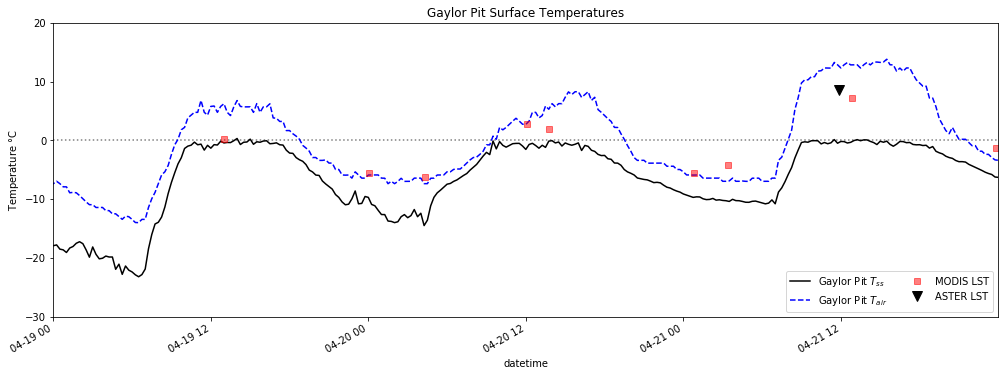

In [8]:
starttime = pd.to_datetime('2017-04-19 00:00')
endtime = pd.to_datetime('2017-04-21 23:59:59')

fig, ax = plt.subplots(figsize=(15,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')

modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)

aster_time = pd.to_datetime('2017-04-21 11:51:07')
aster_LST = 8.55
plt.plot(aster_time,aster_LST,'v',color='k',markersize=10,label='ASTER LST')

#plt.errorbar(modis.datetime,modis.temp_mean,
#             yerr=np.array((modis.temp_max-modis.temp_min)/2),
#             linestyle='None',c='r',linewidth=1.5,
#             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))
#

plt.subplots_adjust(right=1)
plt.legend(loc='lower right',ncol=2) #bbox_to_anchor=(0.0, -0.05)
ax.set_xlim((starttime,endtime))
ax.set_ylim((-30,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Surface Temperatures');
plt.savefig('GaylorPit-MODIS-ASTER-LST-timeline.png',dpi=300)

Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair
Then plot MODIS LST vs Gaylor Pit Tsnow and Tair to see how they compare...

In [9]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

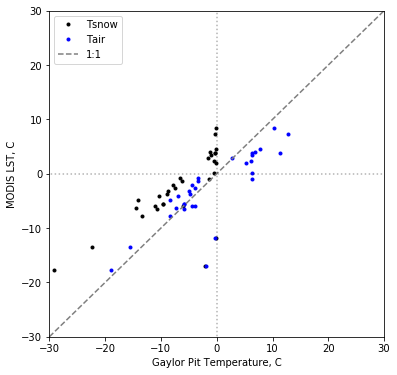

In [10]:
# Compute the difference in temperatures (Gaylor Pit - MODIS)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []

i = 0
for time in modis['datetime']:
    gaylor_time = (nearest(gaylor['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    #modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    #modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gaylor_tsnow[i])
    delta_tair.append(modis_t - gaylor_tair[i])
    i+=1

    


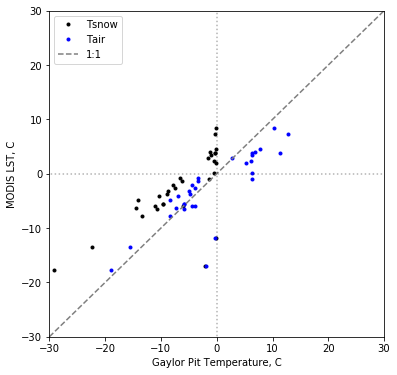

In [14]:
plt.figure(figsize=(6,6))
plt.plot(gaylor_tsnow,modis.temperature,'.k',label='Tsnow')
plt.plot(gaylor_tair,modis.temperature,'.b',label='Tair')
plt.plot([-30,30],[-30,30],'--',c='tab:grey',label='1:1')
plt.plot([0,0],[-100,100],':',c='k',alpha=0.3)
plt.plot([-100,100],[0,0],':',c='k',alpha=0.3)
#plt.text(10,-30,'MODIS colder')
#plt.text(-30,19,'MODIS warmer')
plt.xlabel('Gaylor Pit Temperature, C')
plt.ylabel('MODIS LST, C')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.legend()
plt.savefig('GaylorPit-vs-MODIS-LST.png',dpi=300)

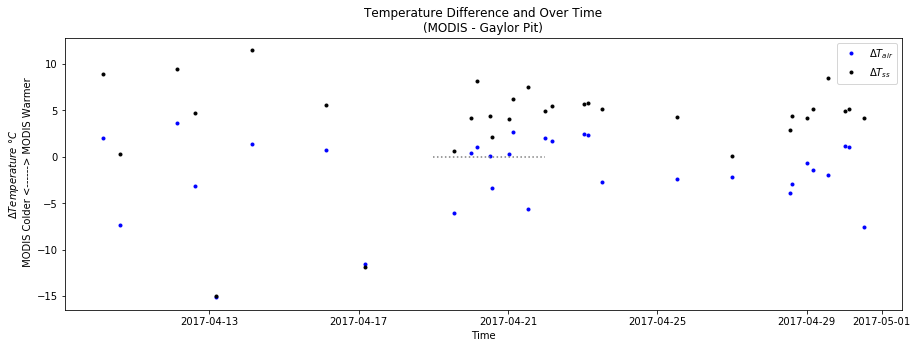

In [15]:
# How does the difference between MODIS LST and ground data change as a function of time?

plt.figure(figsize=(15,5))
plt.plot(modis.datetime,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis.datetime,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Time')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Over Time\n(MODIS - Gaylor Pit)');

plt.savefig('GaylorPit-MODIS-deltaLST-timeline.png',dpi=300)

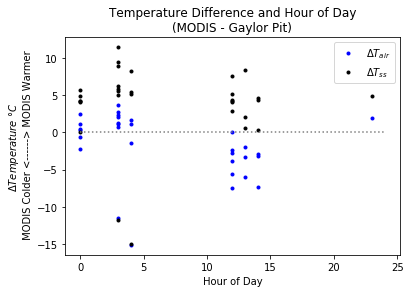

In [16]:
# How does the difference between MODIS LST and ground data change as a function of hour of day?

plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Hour of Day')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([0, 24],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Hour of Day\n(MODIS - Gaylor Pit)');

plt.savefig('GaylorPit-MODIS-deltaLST-hour-of-day.png',dpi=300)

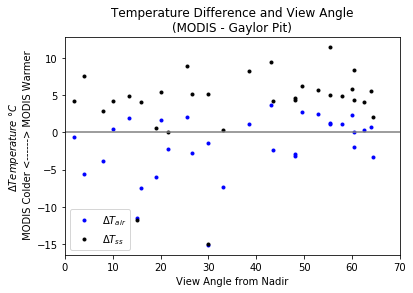

In [17]:
# How does the difference between MODIS LST and ground data change as a function of view angle?

plt.plot(modis.viewangle,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

plt.savefig('GaylorPit-MODIS-deltaLST-view-angle.png',dpi=300)

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [ ]:
snow_fraction = []
for i in range(0,len(modis.temperature)):
    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))


In [ ]:
plt.plot(modis['viewangle'],snow_fraction,'.k');
plt.xlabel('View Angle from Nadir')
plt.ylabel('Estimated Visible Snow Fraction')
plt.xlim([0,70])
plt.ylim([-1,1])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair

#plt.savefig('GaylorPit-MODIS-fsca-test.png',dpi=300)

What's the spread between Tsnow and Tair over time?

In [ ]:
starttime = pd.to_datetime('2017-04-09 00:00')
endtime = pd.to_datetime('2017-04-30 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

plt.plot(gaylor.datetime,gaylor.Judd_Air_TempC-gaylor.TT_C, color='r', label= 'Gaylor Pit $T_{air}$ - $T_{ss}$')
gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Air-Snow Surface Temperatures');
plt.savefig('Gaylor Pit Air-Snow Surface Temperatures.png',dpi=300)